In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN,MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score

In [53]:
df1 = pd.read_csv("dataset/cleaned_dataset.csv")
df2 = pd.read_csv("dataset/cleaned_dataset_v2.csv")

In [54]:
def split_data(df, target_column='Churn', test_size=0.2, random_state=42):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [55]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

Pour obtenir une classification robuste, il est possible de combiner la méthode de la Classification Ascendante Hiérarchique (CAH) avec celle des k-means. La CAH nous permettra de déterminer le nombre optimal de classes 𝑘, qui sera ensuite utilisé comme paramètre dans la méthode k-means pour affiner les clusters.

##### Recherche du nombre de cluster optimal

In [56]:
hc=linkage(df2,method="ward",metric='euclidean')
inertia = hc[-15:, 2]
# Calculer le nombre de clusters correspondant
num_clusters = range(1, len(inertia) + 1)

##### Visualisation du dendogramme et le diagramme de la perte d'inertie

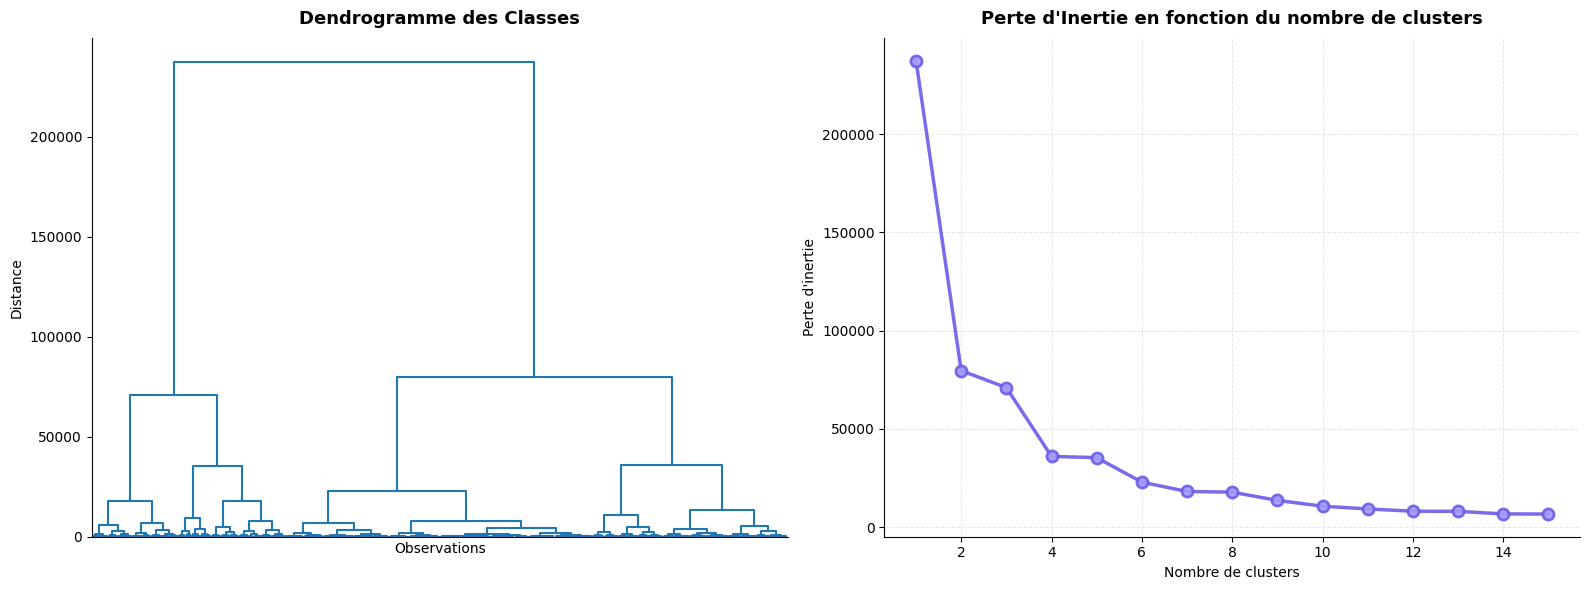

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Dendrogramme
dendrogram(hc, labels=None, color_threshold=0, ax=axes[0], no_labels=True)
axes[0].set_title("Dendrogramme des Classes", fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel("Observations", fontsize=10)
axes[0].set_ylabel("Distance", fontsize=10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
# Courbe du coude 
axes[1].plot(num_clusters, inertia[::-1], marker='o', linewidth=2.5, markersize=8,color='#6c5ce7',markerfacecolor='#a29bfe',markeredgecolor='#6c5ce7',markeredgewidth=2,linestyle='-',alpha=0.9)
axes[1].set_title("Perte d'Inertie en fonction du nombre de clusters", fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel("Nombre de clusters", fontsize=10)
axes[1].set_ylabel("Perte d'inertie", fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].set_axisbelow(True)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#fig.suptitle("Analyse de Clustering Hiérarchique", fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

Le tracé de la perte d'inertie nous incite à choisir une partition en 4 groupes (lecture de gauche à droite : juste avant le coude ou changement de pente s'opérant au passage de 3 à  4 groupes). 
Pour initialiser l'algorithme kmeans nous utilisons les résultats trouvés par la CAH : le nombre de classe optimal k=4 de la CAH. Ainsi nous obtenons: 

##### Méthode Kmeans

In [58]:
k=4
kmeans = KMeans(n_clusters=k, n_init=50)
kmeans.fit(df2)
label=kmeans.labels_
clusters = fcluster(hc, k, criterion='maxclust')
df_clusters = df2.copy()
df_clusters["Cluster"] = clusters

In [59]:
df_clusters.to_csv("dataset/cleaned_datasetclusters.csv")

Evaluation de la performance des clusters avec l'indice de Silhouette

In [60]:
sil_score = silhouette_score(df2, df_clusters["Cluster"], metric="euclidean")
print(f"Indice de silhouette global : {sil_score:.3f}")

Indice de silhouette global : 0.583


##### Visualisation des clusteurs avec l'algorithme TSNE

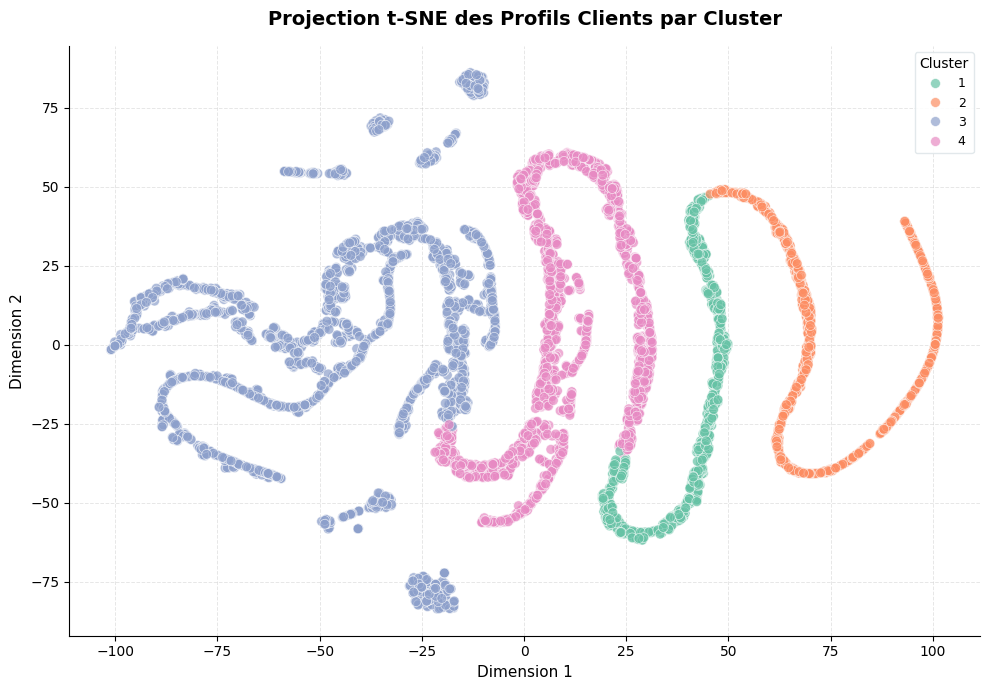

In [61]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(df2)
# Figure
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')
# Scatter plot
sns.scatterplot(x=X_tsne[:, 0],y=X_tsne[:, 1],hue=df_clusters["Cluster"],palette="Set2",s=50,alpha=0.7,edgecolor='white',linewidth=0.5,ax=ax)
# Styling
ax.set_title("Projection t-SNE des Profils Clients par Cluster", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Dimension 1", fontsize=11)
ax.set_ylabel("Dimension 2", fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)
# Légende propre
legend = ax.legend(title="Cluster", frameon=True, loc='upper right', fontsize=9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('#dfe6e9')
plt.tight_layout()
plt.show()

### Feature Engenering 

In [62]:
df = pd.read_csv('dataset/dataset_churn_equilibre.csv')
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

df = df.drop(columns=['Churn_Period', 'Churn'], errors='ignore')
hc=linkage(df,method="ward",metric='euclidean')
inertia = hc[-15:, 2]
# Calculer le nombre de clusters correspondant
num_clusters = range(1, len(inertia) + 1)

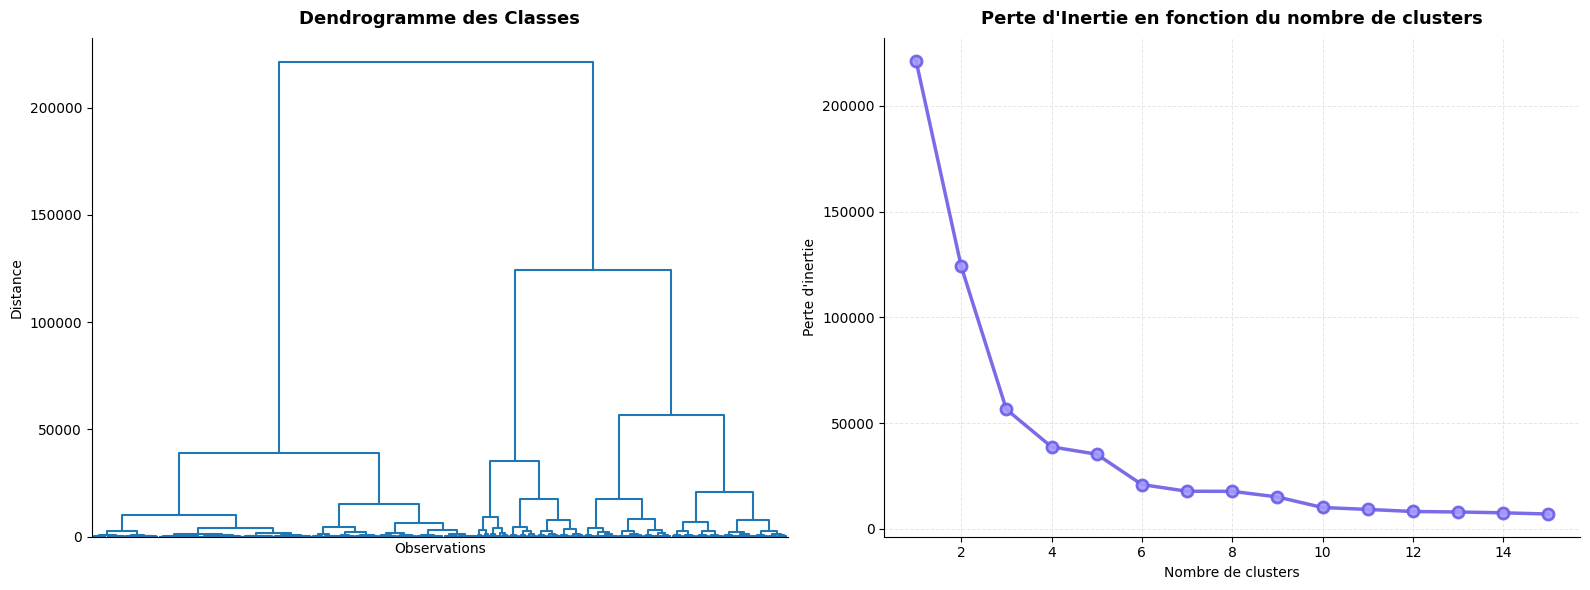

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Dendrogramme
dendrogram(hc, labels=None, color_threshold=0, ax=axes[0], no_labels=True)
axes[0].set_title("Dendrogramme des Classes", fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel("Observations", fontsize=10)
axes[0].set_ylabel("Distance", fontsize=10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
# Courbe du coude 
axes[1].plot(num_clusters, inertia[::-1], marker='o', linewidth=2.5, markersize=8,color='#6c5ce7',markerfacecolor='#a29bfe',markeredgecolor='#6c5ce7',markeredgewidth=2,linestyle='-',alpha=0.9)
axes[1].set_title("Perte d'Inertie en fonction du nombre de clusters", fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel("Nombre de clusters", fontsize=10)
axes[1].set_ylabel("Perte d'inertie", fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].set_axisbelow(True)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#fig.suptitle("Analyse de Clustering Hiérarchique", fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

--- Répartition des catégories de Churn par Cluster (en %) ---
Churn_Category      0      1      2      3      4
Cluster                                          
0               65.81  12.90   9.89   6.88   4.52
1               43.84   8.39  15.41  16.95  15.41
2               92.60   4.11   1.64   1.07   0.58
3               94.99   0.00   0.00   0.61   4.40
4               57.25   8.80  12.35  13.43   8.18
5               85.17   0.00   0.00   0.00  14.83
6               40.25  21.82  15.03  14.49   8.41
7               78.90   7.85   6.38   4.54   2.33


<Figure size 1200x600 with 0 Axes>

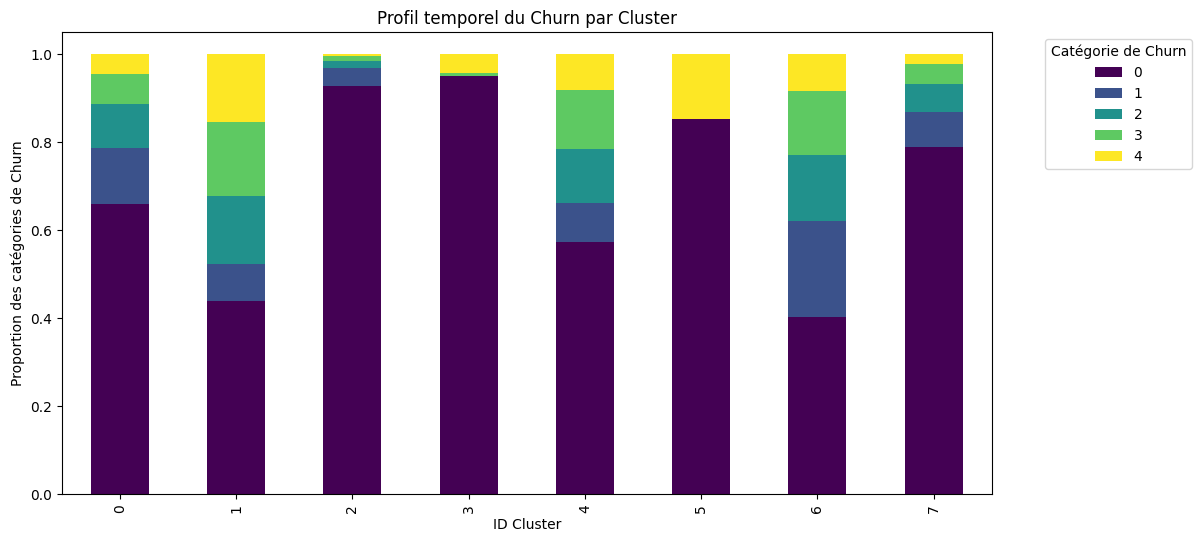

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#
# Nettoyage des colonnes cibles redondantes
# Supposons que Churn_Encoded contient 0 (Non-Churn), 1 (3 mois), 2 (6 mois), etc.
X = df.drop(columns=[ 'Churn_Encoded'], errors='ignore')
y = df['Churn_Encoded']

# 2. Feature Engineering Amélioré
# Création de ratios pour aider le clustering à voir la dynamique temporelle
df['Charges_par_mois_reel'] = df['TotalCharges'] / (df['tenure'] + 1)
X['Charges_par_mois_reel'] = df['Charges_par_mois_reel']

# On se concentre sur les drivers qui influencent le TEMPS avant départ
variables_cles = [
    'Contract', 'MonthlyCharges', 'TotalCharges',
    'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 
    'Charges_par_mois_reel','PaperlessBilling','StreamingMovies_Yes','InternetService_No','InternetService_Fiber optic'
]

# 3. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Standardisation ciblée
# On scale uniquement les variables clés pour le clustering afin de ne pas diluer l'info
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[variables_cles])
X_test_scaled = scaler.transform(X_test[variables_cles])

# 5. Clustering (K=5 pour essayer de matcher les 4 catégories de churn + 1 stable)
kmeans = KMeans(n_clusters=8, n_init=50, random_state=42)
X_train['Cluster'] = kmeans.fit_predict(X_train_scaled)
X_test['Cluster'] = kmeans.predict(X_test_scaled)

# 6. ANALYSE MULTI-CLASSE (Le changement majeur)
# On crée une table croisée pour voir la répartition des catégories de churn par cluster
train_analysis = X_train.copy()
train_analysis['Churn_Category'] = y_train

# Tableau de contingence (Pourcentages de chaque catégorie de churn par cluster)
cluster_profile = pd.crosstab(train_analysis['Cluster'], train_analysis['Churn_Category'], normalize='index')

print("--- Répartition des catégories de Churn par Cluster (en %) ---")
print((cluster_profile * 100).round(2))

# 7. Visualisation de la "Signature Temporelle" des clusters
plt.figure(figsize=(12, 6))
cluster_profile.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12,6))
plt.title('Profil temporel du Churn par Cluster')
plt.xlabel('ID Cluster')
plt.ylabel('Proportion des catégories de Churn')
plt.legend(title='Catégorie de Churn', bbox_to_anchor=(1.05, 1))
plt.show()

# 8. Préparation finale (One-Hot Encoding pour LightGBM multi-class)
X_train_final = pd.get_dummies(X_train, columns=['Cluster'], prefix='Seg')
X_test_final = pd.get_dummies(X_test, columns=['Cluster'], prefix='Seg')

--- Qualité des 8 Segments ---
Silhouette (Cohésion) : 0.346  (>0.25 est bon pour ce dataset)
Davies-Bouldin (Séparation) : 1.234 (Plus c'est bas, mieux c'est)
Calinski-Harabasz : 2358.5

--- Analyse de Stabilité ---
         Train %  Test %
Cluster                 
0           8.25    8.16
1          10.37   10.65
2          21.58   22.00
3          11.70   10.65
4          11.50   12.28
5          12.21   11.00
6           9.92    9.87
7          14.47   15.40


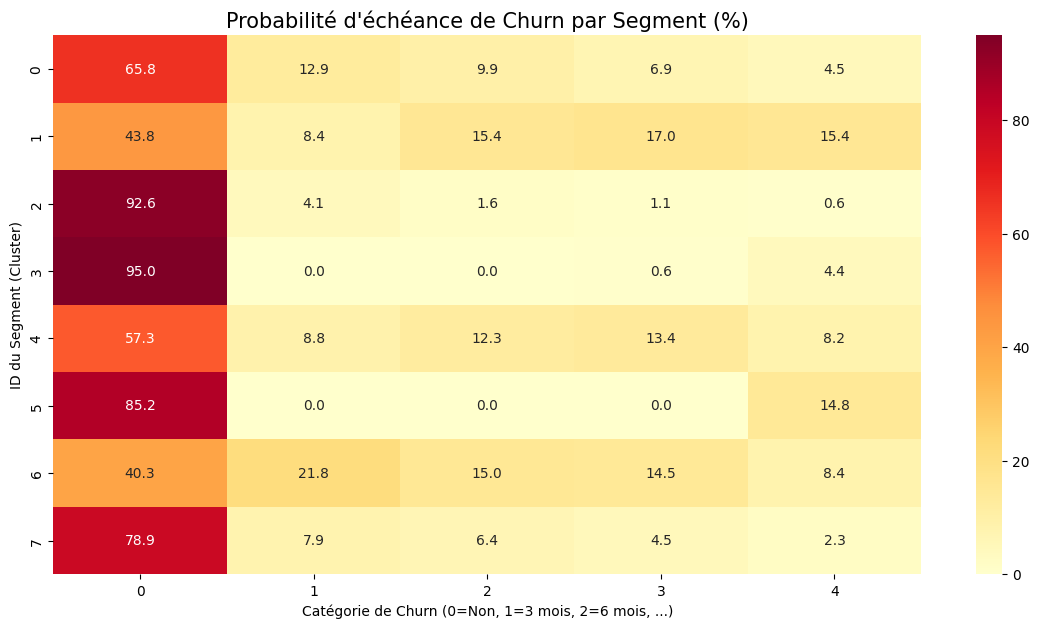

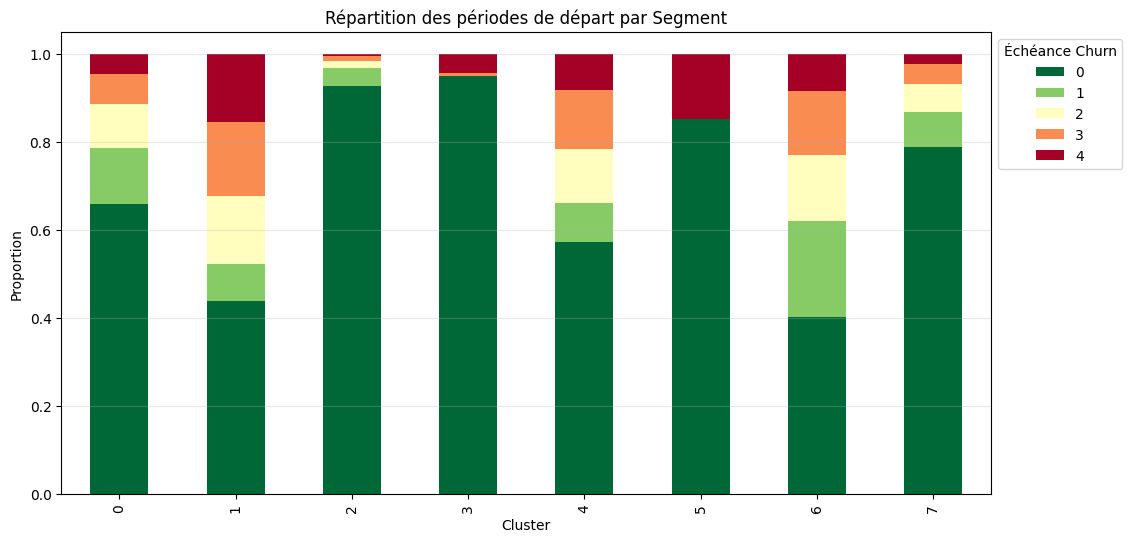

In [65]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluer_clustering_multiclasse(X_train_scaled, X_train, X_test, y_train):
    # --- 1. MÉTRIQUES MATHÉMATIQUES ---
    sil = silhouette_score(X_train_scaled, X_train['Cluster'])
    db = davies_bouldin_score(X_train_scaled, X_train['Cluster'])
    ch = calinski_harabasz_score(X_train_scaled, X_train['Cluster'])

    print(f"--- Qualité des 8 Segments ---")
    print(f"Silhouette (Cohésion) : {sil:.3f}  (>0.25 est bon pour ce dataset)")
    print(f"Davies-Bouldin (Séparation) : {db:.3f} (Plus c'est bas, mieux c'est)")
    print(f"Calinski-Harabasz : {ch:.1f}")

    # --- 2. STABILITÉ TRAIN/TEST ---
    train_dist = X_train['Cluster'].value_counts(normalize=True).sort_index() * 100
    test_dist = X_test['Cluster'].value_counts(normalize=True).sort_index() * 100
    
    stabilité = pd.DataFrame({'Train %': train_dist, 'Test %': test_dist})
    print("\n--- Analyse de Stabilité ---")
    print(stabilité.round(2))

    # --- 3. SIGNATURE TEMPORELLE (Le plus important) ---
    # On regarde quel % de chaque classe de Churn tombe dans chaque cluster
    # y_train contient : 0 (Non-Churn), 1 (3m), 2 (6m), 3 (9m), 4 (12m)
    matrice_contingence = pd.crosstab(X_train['Cluster'], y_train, normalize='index')

    plt.figure(figsize=(14, 7))
    sns.heatmap(matrice_contingence * 100, annot=True, fmt=".1f", cmap="YlOrRd")
    plt.title('Probabilité d\'échéance de Churn par Segment (%)', fontsize=15)
    plt.xlabel('Catégorie de Churn (0=Non, 1=3 mois, 2=6 mois, ...)')
    plt.ylabel('ID du Segment (Cluster)')
    plt.show()

    # --- 4. VISUALISATION DES PROFILS (BARRES EMPIILÉES) ---
    matrice_contingence.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='RdYlGn_r')
    plt.title('Répartition des périodes de départ par Segment')
    plt.legend(title="Échéance Churn", bbox_to_anchor=(1,1))
    plt.ylabel('Proportion')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    return matrice_contingence

# Utilisation
resultats_contingence = evaluer_clustering_multiclasse(X_train_scaled, X_train, X_test, y_train)

In [66]:
import joblib

# Création d'un dictionnaire pour tout regrouper
clustering_artifacts = {
    'kmeans_model': kmeans,
    'scaler_cluster': scaler,
    'variables_cles': variables_cles
}

# Sauvegarde dans un fichier unique
joblib.dump(clustering_artifacts, 'modele_clustering_telecom.joblib')

print("Modèle KMeans et Scaler sauvegardés dans 'modele_clustering_telecom.joblib'")

Modèle KMeans et Scaler sauvegardés dans 'modele_clustering_telecom.joblib'


#  Rapport d'Analyse : Segmentation Temporelle du Churn

## 1. État des Lieux de la Population
L'analyse initiale montre une base de clients majoritairement stable, mais avec une érosion significative qui nécessite une stratégie de prédiction ciblée.

* **Volume de Clients Actifs :** 5174 (73.5% de la population).
* **Volume de Churners :** 1869 clients répartis sur différentes échéances.

## 2. Problématique : De la Prédiction Binaire à la Prédiction Temporelle
Au lieu de simplement prédire *si* un client va partir, nous cherchons à prédire **quand** il partira. L'analyse de la variable `tenure` (ancienneté) révèle un phénomène de churn précoce massif :
* **Pic critique :** 597 départs surviennent dès la tranche 0-3 mois.
* **Tendance :** Le volume de départ diminue drastiquement avec l'ancienneté, stabilisant la base de clients sur le long terme.

## 3. Méthodologie : Création de Tranches Équilibrées
Pour optimiser l'apprentissage du modèle (éviter le biais vers les nouveaux clients), nous avons segmenté la population de churners en **4 tranches de fréquences égales (Quantiles)**.

| Tranche Temporelle | Volume de Churners | Poids (Pop. Totale) |
| :--- | :--- | :--- |
| **1-2 mois** | 503 | 7.1% |
| **2-10 mois** | 465 | 6.6% |
| **10-29 mois** | 441 | 6.3% |
| **29-72 mois** | 460 | 6.5% |

> **Résultat :** Cette distribution équilibrée garantit que le modèle apprendra avec la même précision les signaux de départ immédiat et de départ à long terme.

---

## 4. Analyse des Segments et Corrélation Prix
L'intégration des 8 clusters de segmentation permet de définir des "signatures" de risque spécifiques.

### Impact de la tarification
On observe une corrélation entre les charges mensuelles et la rapidité du churn :
* **Churn Tardif (42-72 mois) :** Présente des médianes de prix plus élevées (souvent > 90$), suggérant une fatigue tarifaire après plusieurs années.
* **Churn Précoce :** Très dispersé, indiquant que d'autres facteurs (service client, installation) priment sur le prix au début.

### Signature Temporelle par Cluster
L'analyse croisée montre que certains clusters sont des "spécialistes" :
* **Segments de Sécurité (ex: Cluster 3) :** 95% de clients actifs, idéal pour éliminer les faux positifs.
* **Segments d'Alerte (ex: Cluster 6) :** Présente le plus fort taux de churn à court terme (21.8% en catégorie 1).

---

## 5. Conclusion pour la Modélisation
La transformation de la `tenure` en classes équilibrées, combinée aux 8 clusters agissant comme des **super-indices**, prépare idéalement le terrain pour un modèle multi-classe (LightGBM). Le modèle ne verra plus seulement des données brutes, mais des profils clients déjà pré-identifiés par leur risque temporel.